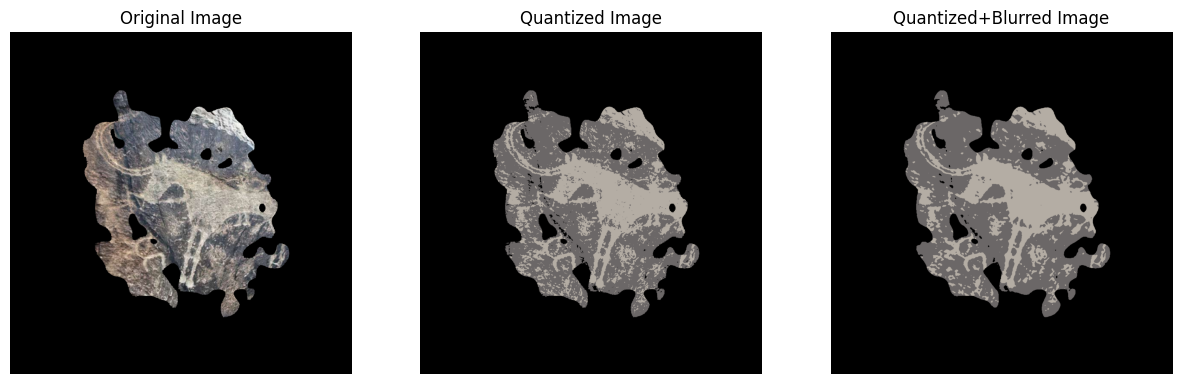

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

image = cv2.imread('pre_segmented_results/segmented_1.png')

pixels = image.reshape((-1, 3))
pixels = np.float32(pixels)

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)

k = 3

ret, labels, centers = cv2.kmeans(pixels, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

centers = np.uint8(centers)

quantized_image = centers[labels.flatten()]

quantized_image = quantized_image.reshape((image.shape))

median_blurred_image = cv2.medianBlur(quantized_image, 5)

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Quantized Image')
plt.imshow(cv2.cvtColor(quantized_image, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Quantized+Blurred Image')
plt.imshow(cv2.cvtColor(median_blurred_image, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.show()

In [2]:
def unsupervised_segmentation(image, k, spatial_weight=1.0):
    """
    Performs unsupervised segmentation using K-Means on color and spatial features.
    
    Args:
        image (np.array): The input BGR image.
        k (int): The number of desired segments (clusters).
        spatial_weight (float): How much to weight the pixel coordinates. Tune this value.
    
    Returns:
        The segmented image.
    """
    h, w, _ = image.shape

    # --- 1. Create the Feature Vector ---
    # Reshape the image to a list of pixels (N, 3)
    pixels = image.reshape((-1, 3))
    pixels = np.float32(pixels)

    # Create the (x, y) coordinates for each pixel
    # np.mgrid creates two grids, one for y-coordinates and one for x-coordinates
    yy, xx = np.mgrid[0:h, 0:w]
    
    # Reshape the coordinate grids to be single columns
    xy_features = np.stack((xx.flatten(), yy.flatten()), axis=1)
    
    # Apply the spatial weight. This balances color vs. position.
    # We normalize coordinates to be roughly in the same range as colors.
    xy_features = np.float32(xy_features) * spatial_weight * (255 / max(h, w))
    
    # Concatenate color features and spatial features
    # Each pixel is now represented by (B, G, R, X, Y)
    features = np.concatenate((pixels, xy_features), axis=1)

    # --- 2. Apply K-Means Clustering ---
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
    ret, labels, centers = cv2.kmeans(features, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

    # --- 3. Reconstruct the Segmented Image ---
    # The 'centers' now have 5 dimensions. We only care about the first 3 (the color part).
    quantized_colors = np.uint8(centers[:, :3])
    
    # Map each label to its corresponding color
    quantized_image = quantized_colors[labels.flatten()]
    
    # Reshape the image back to its original dimensions
    quantized_image = quantized_image.reshape((image.shape))
    
    return labels, centers, quantized_image

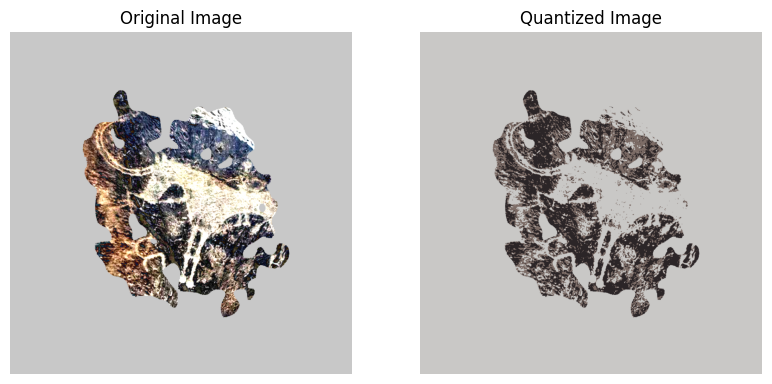

In [3]:
alpha = 2.5
beta = -200

image = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)

pixels = image.reshape((-1, 3))
pixels = np.float32(pixels)

labels, centers, quantized_image = unsupervised_segmentation(image, k = 3, spatial_weight=0.0)

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Quantized Image')
plt.imshow(cv2.cvtColor(quantized_image, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.show()

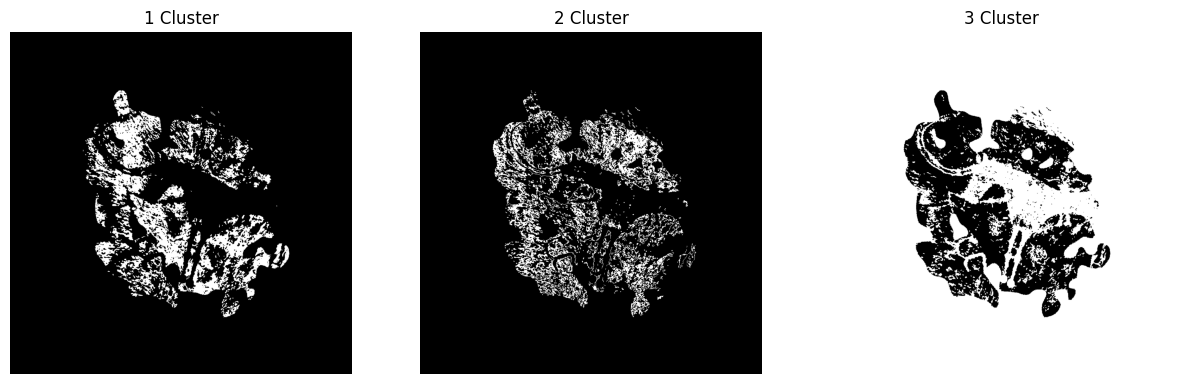

In [4]:
min_area_threshold = 5

cluster_to_display = 0 
mask = np.uint8(labels.flatten() == cluster_to_display) * 255
mask = mask.reshape(image.shape[:2])

num_labels, labels_map, stats, centroids = cv2.connectedComponentsWithStats(mask, 4, cv2.CV_32S)

mask = np.zeros_like(mask)

for i in range(1, num_labels):
        if stats[i, cv2.CC_STAT_AREA] >= min_area_threshold:
            mask[labels_map == i] = 255
first_cluster_image = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)

cluster_to_display = 1
mask = np.uint8(labels.flatten() == cluster_to_display) * 255
mask = mask.reshape(image.shape[:2])

num_labels, labels_map, stats, centroids = cv2.connectedComponentsWithStats(mask, 4, cv2.CV_32S)

mask = np.zeros_like(mask)

for i in range(1, num_labels):
        if stats[i, cv2.CC_STAT_AREA] >= min_area_threshold:
            mask[labels_map == i] = 255

second_cluster_image = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)

cluster_to_display = 2
mask = np.uint8(labels.flatten() == cluster_to_display) * 255
mask = mask.reshape(image.shape[:2])

num_labels, labels_map, stats, centroids = cv2.connectedComponentsWithStats(mask, 4, cv2.CV_32S)

mask = np.zeros_like(mask)

for i in range(1, num_labels):
        if stats[i, cv2.CC_STAT_AREA] >= min_area_threshold:
            mask[labels_map == i] = 255
third_cluster_image = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.title('1 Cluster')
plt.imshow(cv2.cvtColor(first_cluster_image, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('2 Cluster')
plt.imshow(cv2.cvtColor(second_cluster_image, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('3 Cluster')
plt.imshow(cv2.cvtColor(third_cluster_image, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.show()

In [27]:
import torch
import torch.nn as nn
from transformers import Dinov2Model

class DINOv2SegmentationHead(nn.Module):
    def __init__(self, dino_model_name="facebook/dinov2-base"):
        super().__init__()
        
        self.dinov2 = Dinov2Model.from_pretrained(dino_model_name)
        
        for param in self.dinov2.parameters():
            param.requires_grad = False
            
        self.head = nn.Sequential(
            nn.Conv2d(768, 256, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(256), # Добавление BatchNorm улучшает стабильность
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            
            nn.Conv2d(256, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            
            nn.Conv2d(64, 1, kernel_size=1)
        )

    def forward(self, pixel_values):
        self.dinov2.eval()
        
        outputs = self.dinov2(pixel_values)
        patch_features = outputs.last_hidden_state
        
        batch_size, _, channels = patch_features.shape
        height = width = int((patch_features.shape[1] - 1) ** 0.5)
        
        features_2d = patch_features[:, 1:, :].reshape(batch_size, height, width, channels)
        features_2d = features_2d.permute(0, 3, 1, 2)
        
        segmentation_logits = self.head(features_2d)
        
        # --- КЛЮЧЕВОЕ ИСПРАВЛЕНИЕ ---
        # Вместо жестко заданного scale_factor, мы динамически берем
        # размер входного изображения и апскейлим точно до этого размера.
        target_height, target_width = pixel_values.shape[-2:]
        
        final_logits = nn.functional.interpolate(
            segmentation_logits,
            size=(target_height, target_width), # <-- Используем размер входа
            mode='bilinear',
            align_corners=False
        )
        
        return final_logits


In [35]:
import os
import glob
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2
from transformers import Dinov2Model, AutoImageProcessor
from scipy.ndimage import distance_transform_edt

DATA_DIR = "dataset"
IMAGE_DIR = os.path.join(DATA_DIR, "images")
MASK_DIR = os.path.join(DATA_DIR, "masks")
MODEL_OUTPUT_PATH = "dinov2_segmentation_model.pth"

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
LEARNING_RATE = 1e-4
BATCH_SIZE = 4
NUM_EPOCHS = 10
IMG_HEIGHT = 1400
IMG_WIDTH = 1400

In [36]:
image_processor = AutoImageProcessor.from_pretrained("facebook/dinov2-base")
    
train_transform = A.Compose([
        A.Resize(height=IMG_HEIGHT, width=IMG_WIDTH),
        A.HorizontalFlip(p=0.5),
        A.Normalize(mean=image_processor.image_mean, std=image_processor.image_std),
        ToTensorV2(),
])

In [104]:
class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_filename = self.images[index]
        img_path = os.path.join(self.image_dir, img_filename)
        image = np.array(Image.open(img_path).convert("RGB"))
        
        base_name = os.path.splitext(img_filename)[0]
        
        mask_pattern = os.path.join(self.mask_dir, f"{base_name}-*.png")
        mask_paths = glob.glob(mask_pattern)
        
        combined_mask = np.zeros((image.shape[0], image.shape[1]), dtype=np.float32)

        if not mask_paths:
            print(f"Внимание: не найдено масок для изображения {img_filename}")
        else:
            for mask_path in mask_paths:
                individual_mask = np.array(Image.open(mask_path).convert("L"))
                combined_mask = np.logical_or(combined_mask, individual_mask)

        combined_mask = combined_mask.astype(np.float32)

        if self.transform is not None:
            augmentations = self.transform(image=image, mask=combined_mask)
            image = augmentations["image"]
            mask = augmentations["mask"]
            
        return image, mask, base_name+".png"

In [105]:
import torch
import torch.nn as nn
import segmentation_models_pytorch as smp
from scipy.ndimage import distance_transform_edt

class BoundaryLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, pred_sigmoid, gt_float):
        gt_numpy = gt_float.cpu().numpy()
        dist_maps = np.zeros_like(gt_numpy)
        for i in range(gt_numpy.shape[0]):
            gt_instance = gt_numpy[i, 0, :, :]
            neg_mask = 1 - gt_instance
            dist_maps[i, 0, :, :] = distance_transform_edt(neg_mask) * gt_instance
        
        dist_maps = torch.from_numpy(dist_maps).float().to(pred_sigmoid.device)
        multipled = pred_sigmoid * dist_maps
        loss = multipled.mean()
        return loss

# А теперь главный класс SuperLoss
class SuperLoss(nn.Module):
    """
    Комбинированная функция потерь: BCE + Dice + Boundary.
    """
    def __init__(self, alpha=0.5, beta=0.4, gamma=0.1):
        """
        Инициализация весов для каждого компонента.
        alpha: вес для BCE (пиксели)
        beta: вес для Dice (форма)
        gamma: вес для Boundary (границы)
        """
        super().__init__()
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        
        # Инициализируем каждого "специалиста"
        self.bce = nn.BCEWithLogitsLoss()
        self.dice = smp.losses.DiceLoss(mode='binary')
        self.boundary = BoundaryLoss()
        
    def forward(self, pred_logits, true_float):
        bce_loss = self.bce(pred_logits, true_float)
        dice_loss = self.dice(pred_logits, true_float)
        
        pred_sigmoid = torch.sigmoid(pred_logits)
        boundary_loss = self.boundary(pred_sigmoid, true_float)
        
        total_loss = self.alpha * bce_loss + self.beta * dice_loss + self.gamma * boundary_loss
        
        return total_loss

In [106]:
train_dataset = SegmentationDataset(image_dir=IMAGE_DIR, mask_dir=MASK_DIR, transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [40]:
print("Загрузка и настройка модели DINOv2...")
model = DINOv2SegmentationHead().to(DEVICE)
    
loss_fn = SuperLoss(alpha=0.5, beta=0.4, gamma=0.1)
    
optimizer = optim.Adam(model.head.parameters(), lr=LEARNING_RATE)

Загрузка и настройка модели DINOv2...


In [ ]:
for epoch in range(NUM_EPOCHS):
        model.train() # Переводим "голову" в режим обучения
        loop = tqdm(train_loader, leave=True)
        running_loss = 0.0

        for data, targets, _ in loop:
            data = data.to(device=DEVICE)
            # Изменяем размер масок до размера выхода модели для подсчета loss
            targets_resized = nn.functional.interpolate(targets.unsqueeze(1), size=(IMG_HEIGHT, IMG_WIDTH), mode='nearest')
            targets_resized = targets_resized.to(device=DEVICE)
            
            # Forward pass
            predictions = model(data)
            loss = loss_fn(predictions, targets_resized)
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            loop.set_postfix(loss=loss.item())
            
        print(f"Эпоха {epoch+1}/{NUM_EPOCHS}, Средняя потеря: {running_loss/len(train_loader):.4f}")

torch.save(model.head.state_dict(), MODEL_OUTPUT_PATH)
print(f"--- Обучение завершено, 'голова' модели сохранена в {MODEL_OUTPUT_PATH}! ---")

  0%|          | 0/17 [00:00<?, ?it/s]

100%|██████████| 17/17 [01:10<00:00,  4.15s/it, loss=0.41] 


Эпоха 1/10, Средняя потеря: 0.4472


100%|██████████| 17/17 [01:09<00:00,  4.10s/it, loss=0.381]


Эпоха 2/10, Средняя потеря: 0.3887


100%|██████████| 17/17 [01:09<00:00,  4.07s/it, loss=0.327]


Эпоха 3/10, Средняя потеря: 0.3568


100%|██████████| 17/17 [01:09<00:00,  4.08s/it, loss=0.333]


Эпоха 4/10, Средняя потеря: 0.3321


100%|██████████| 17/17 [01:09<00:00,  4.11s/it, loss=0.32] 


Эпоха 5/10, Средняя потеря: 0.3155


100%|██████████| 17/17 [01:08<00:00,  4.06s/it, loss=0.334]


Эпоха 6/10, Средняя потеря: 0.3044


100%|██████████| 17/17 [01:09<00:00,  4.12s/it, loss=0.258]


Эпоха 7/10, Средняя потеря: 0.2863


100%|██████████| 17/17 [01:09<00:00,  4.07s/it, loss=0.285]


Эпоха 8/10, Средняя потеря: 0.2775


100%|██████████| 17/17 [01:08<00:00,  4.05s/it, loss=0.269]


Эпоха 9/10, Средняя потеря: 0.2677


100%|██████████| 17/17 [01:08<00:00,  4.04s/it, loss=0.261]

Эпоха 10/10, Средняя потеря: 0.2599
--- Обучение завершено, 'голова' модели сохранена в dinov2_segmentation_model.pth! ---


In [100]:
from torchvision.utils import save_image

def calculate_mpa(
    model, 
    loader, 
    device, 
    output_dir="dino_masks", 
    threshold=0.5
):
    """
    Вычисляет MPA и сохраняет предсказанные маски в указанную папку.

    Args:
        model (torch.nn.Module): Обученная модель.
        loader (torch.utils.data.DataLoader): Загрузчик данных.
        device (str): Устройство.
        output_dir (str): Папка для сохранения масок.
        threshold (float): Порог бинаризации.

    Returns:
        float: Средняя попиксельная точность (MPA).
    """
    print(f"--- Начало вычисления MPA и сохранения масок в '{output_dir}' ---")
    
    # Создаем папку для вывода, если ее нет
    os.makedirs(output_dir, exist_ok=True)
    
    model.eval()
    total_pixel_accuracy = 0.0
    num_samples = 0
    
    with torch.no_grad():
        # loader теперь возвращает (images, true_masks, filenames)
        for images, true_masks, filenames in tqdm(loader):
            images = images.to(device)
            # Изменяем размер истинных масок до размера входа модели
            # для корректного подсчета метрики
            h, w = images.shape[-2:]
            true_masks_resized = torch.nn.functional.interpolate(true_masks.unsqueeze(1), size=(h,w), mode='nearest')
            true_masks_resized = true_masks_resized.to(device)
            
            # 1. Получаем предсказание
            pred_logits = model(images)
            pred_probs = torch.sigmoid(pred_logits)
            
            # 2. Бинаризуем предсказание
            pred_masks_binary = (pred_probs > threshold).float()
            
            # 3. Считаем MPA (как и раньше)
            correct_pixels = (pred_masks_binary == true_masks_resized).sum()
            total_pixels_in_batch = true_masks_resized.numel()
            pixel_accuracy_batch = correct_pixels.double() / total_pixels_in_batch
            total_pixel_accuracy += pixel_accuracy_batch.item()
            num_samples += 1
            
            # --- КЛЮЧЕВОЕ ИЗМЕНЕНИЕ: Сохранение масок ---
            # Проходим по каждой маске в батче
            for i in range(pred_masks_binary.shape[0]):
                mask_tensor = pred_masks_binary[i] # Берем i-ю маску из батча
                filename = filenames[i]            # Берем i-е имя файла
                
                # Создаем полный путь для сохранения
                output_path = os.path.join(output_dir, filename)
                
                # Сохраняем тензор как изображение. save_image автоматически
                # обработает тензор и сохранит его как PNG.
                # Значения 0.0 станут черными, 1.0 - белыми.
                save_image(mask_tensor, output_path)

    mean_accuracy = total_pixel_accuracy / num_samples
    
    print("--- Процесс завершен ---")
    
    return mean_accuracy

In [101]:

# Загружаем нашу кастомную архитектуру
model = DINOv2SegmentationHead().to("cuda")
    
# Загружаем веса нашей обученной "головы"
try:
    model.head.load_state_dict(torch.load(MODEL_OUTPUT_PATH, map_location="cuda"))
    print("Веса дообученной 'головы' успешно загружены.")
except Exception as e:
    print(f"Ошибка загрузки весов модели из '{MODEL_OUTPUT_PATH}': {e}")
    print("Убедитесь, что файл существует и вы завершили обучение.")
        
model.eval()

Веса дообученной 'головы' успешно загружены.


DINOv2SegmentationHead(
  (dinov2): Dinov2Model(
    (embeddings): Dinov2Embeddings(
      (patch_embeddings): Dinov2PatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(14, 14), stride=(14, 14))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): Dinov2Encoder(
      (layer): ModuleList(
        (0-11): 12 x Dinov2Layer(
          (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (attention): Dinov2SdpaAttention(
            (attention): Dinov2SdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): Dinov2SelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
     

In [107]:
train_loader

In [108]:
mpa_demo = calculate_mpa(model, train_loader, "cuda")
print(f"\nДемонстрационная MPA: {mpa_demo * 100:.2f}%")

--- Начало вычисления MPA и сохранения масок в 'dino_masks' ---


100%|██████████| 17/17 [01:01<00:00,  3.62s/it]

--- Процесс завершен ---

Демонстрационная MPA: 96.70%
